In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Traveling salesman problem

We'll solve a small traveling salesman problem using integer programming. We are given a set of $N$ locations $L \in \mathbb{R}^{N\times 2}$, with a distance matrix $D \in \mathbb{R}^{N\times N}$. We have a set of boolean decision variables $X \in \mathbb{R}^{N\times N}$ where the $X_{ij}$ entry says to travel from the $i$th location to the $j$th location. We will also introduce $N$ slack variables $1 \le u_i \le N-1$ which describes the visitation order for the $i$th location ($u_0$ is fixed to zero).

We want to find the route that minimizes the total distance traveled, while still visiting all the locations, and returning back to the origin. This means we must solve the following problem:

$$
\min_X \sum_{i,j=1}^{N} D_{ij} X_{ij} \\
\text{subject to} \\
\sum_{i=1,i\neq j}^{N} X_{ij} = 1, \qquad
\sum_{j=1,j\neq i}^{N} X_{ij} = 1, \qquad
X_{ii} = 0, \\
u_0 = 0,\,1 \le u_i \le N-1;\, i \in [1, N], \qquad
u_i - u_j + NX_{ij} \le N-1;\, \forall i \neq j
$$

## Using `cvxpy`

In [81]:
import cvxpy as cvx

In [127]:
# Simple traveling salesman problem
N = 25    # number of locations
np.random.seed(1)
locations = np.random.randn(N, 2)    # (x,y) coordinates of the locations
D = squareform(pdist(locations))    # distance matrix between locations

# Location visitation variables; 
X = cvx.Variable((N, N), boolean=True)
u = cvx.Variable(N-1, integer=True)

# Constraints
constraints = [
    cvx.sum(X, axis=0) == 1,
    cvx.sum(X, axis=1) == 1,
    cvx.trace(X) == 0,
    1 <= u, u <= N-1
]
constraints.extend(
    [u[i-1] - u[j-1] + N*X[i,j] <= N-1 for i in range(1, N) for j in range(1, N) if i != j]
)

# Objective
obj = cvx.Minimize(cvx.sum(cvx.multiply(D, X)))

# Problem
prob = cvx.Problem(obj, constraints)
%time prob.solve(solver='GLPK_MI', )

CPU times: user 12.2 s, sys: 43.4 ms, total: 12.3 s
Wall time: 12.2 s


15.573009073860796

In [128]:
print("Problem status:", prob.status)
print("Location index:", np.arange(N))
print("argmax(X):     ", np.argmax(X.value, axis=1))
print("Time of visitation:", [0]+u.value.astype(int).tolist()+[N])

Problem status: optimal
Location index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
argmax(X):      [19 20  5  0 12  3 15  2 13 14 18 24  7 22 23 16  1  6 17 11  8 10  4 21
  9]
Time of visitation: [0, 14, 22, 24, 19, 23, 11, 21, 16, 4, 8, 2, 20, 17, 5, 12, 13, 10, 9, 1, 15, 7, 18, 6, 3, 25]


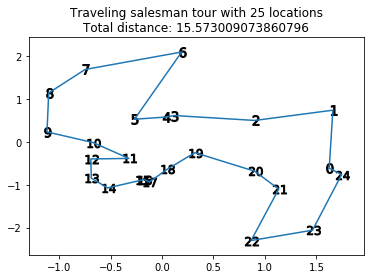

In [129]:
order = list(list(zip(*sorted(
    zip(
        list(range(N))+[0], 
        [0]+u.value.astype(int).tolist()+[N]
    ), 
    key=lambda e: e[1]
)))[0])
tour = locations[order]
plt.plot(*tour.T)
for i, t in enumerate(tour[:-1]):
    plt.scatter(*t, marker=f"${i}$", color='black', s=100*len(str(i)))
plt.title(f"Traveling salesman tour with {N} locations\nTotal distance: {prob.value}")
plt.show()

## Using `MIPCL-PY`

In [1]:
import mipcl_py.mipshell.mipshell as mip

In [94]:
class TSP(mip.Problem):
    def model(self, D):
        # Variables
        self.D = D
        N = len(D)
        self.X = X = mip.VarVector((N, N), 'X', mip.BIN)
        self.u = u = mip.VarVector((N-1,), 'u', mip.INT, lb=1, ub=N-1)
        
        # Constraints
        for i in range(N):
            mip.sum_(X[i]) == 1
            mip.sum_(X[j][i] for j in range(N)) == 1
        mip.sum_(X[i][i] for i in range(N)) == 0
        for i in range(1, N):
            for j in range(1, N):
                if i == j:
                    continue
                u[i-1] - u[j-1] + N*X[i][j] <= N-1
        
        # Objective
        obj = mip.sum_(D[i,j]*X[i][j] for i in range(N) for j in range(N))
        mip.minimize(obj)
    
    @property
    def Xval(self):
        X = self.X
        X = [[X[i][j].val for j in range(len(X[i]))] for i in range(len(X))]
        return np.array(X).astype(int)
    
    @property
    def uval(self):
        u = self.u
        u = np.array([u[i].val for i in range(len(u))])
        return u.astype(int)
        
    def printSolution(self):
        N = len(D)
        X = self.Xval
        u = self.uval
        print("Is optimal:", self.is_solutionOptimal)
        print("Location index:", list(range(N)))
        print("argmax(X):     ", np.argmax(X, axis=1))
        print("Visitation order:", [0]+u.astype(int).tolist()+[0])

In [124]:
N = 25    # number of locations
np.random.seed(1)
locations = np.random.randn(N, 2)    # (x,y) coordinates of the locations
D = squareform(pdist(locations))    # distance matrix between locations

prob = TSP("traveling salesman")
prob.model(D)
%time prob.optimize(False)

CPU times: user 6.75 s, sys: 21.8 ms, total: 6.77 s
Wall time: 1.87 s


In [125]:
prob.printSolution()

Is optimal: True
Location index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
argmax(X):      [19 20  5  0 12  3 15  2 13 14 18 24  7 22 23 16  1  6 17 11  8 10  4 21
  9]
Visitation order: [0, 14, 22, 24, 19, 23, 11, 21, 16, 4, 8, 2, 20, 17, 5, 12, 13, 10, 9, 1, 15, 7, 18, 6, 3, 0]


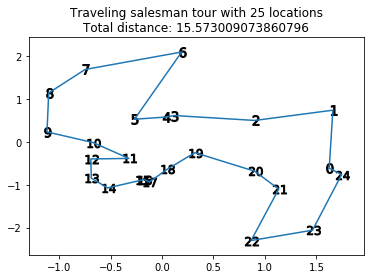

In [126]:
order = []
cycle = np.argmax(prob.Xval, axis=1)
p = 0
while True:
    order.append(p)
    p = cycle[p]
    if p == 0:
        order.append(p)
        break
tour = locations[order]
plt.plot(*tour.T)
for i, t in enumerate(tour[:-1]):
    plt.scatter(*t, marker=f"${i}$", color='black', s=100*len(str(i)))
plt.title(f"Traveling salesman tour with {N} locations\n"\
          f"Total distance: {prob.getObjVal()}")
plt.show()